# 04 - Train Baseline Model

In [24]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#notebook settings
pd.set_option('display.max_columns', None)

from scipy.stats import uniform, randint

# building a pipeline to preprocess the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, validation_curve, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


In [25]:
# Use absolute paths to load the data
train_df = pd.read_csv(r'C:\Users\alexg\Ambiente de Trabalho\Mestrado Data Science NOVA IMS\1st semester\Machine Learning\Project_github\ML_Project_Group52\project\data\processed\prepared_claims_data_train.csv')
test_df = pd.read_csv(r'C:\Users\alexg\Ambiente de Trabalho\Mestrado Data Science NOVA IMS\1st semester\Machine Learning\Project_github\ML_Project_Group52\project\data\processed\prepared_claims_data_test.csv')

print("Train and test datasets loaded successfully.")


Train and test datasets loaded successfully.


In [26]:
train_df.shape

(556330, 52)

In [27]:
test_df.shape

(387975, 50)

In [28]:
train_df.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'Claim Injury Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
       'Industry Code', 'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents',
       'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year',
       'Accident Date_Month', 'Accident Date_Day', 'Assembly Date_Year',
       'Assembly Date_Month', 'Assembly Date_Day', 'C-2 Date_Year',
       'C-2 Date_Month', 'C-2 Date_Day', 'Accident_Year', 'Accident_Month',
       'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day',
       'Assembly_Year', 'Assembly_Month', 'Assembly_Month_Sin',
       'Assembly_Month_Cos', 'Assembly_Day', 'C-2_Year', 'C-2_Month',
       'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day', 'Cause Injury Category',
  

In [29]:
test_df.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents',
       'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year',
       'Accident Date_Month', 'Accident Date_Day', 'Assembly Date_Year',
       'Assembly Date_Month', 'Assembly Date_Day', 'C-2 Date_Year',
       'C-2 Date_Month', 'C-2 Date_Day', 'Accident_Year', 'Accident_Month',
       'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day',
       'Assembly_Year', 'Assembly_Month', 'Assembly_Month_Sin',
       'Assembly_Month_Cos', 'Assembly_Day', 'C-2_Year', 'C-2_Month',
       'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day', 'Cause Injury Category',
       'Nature of Injur

# Retrieving the target variable (encoded before)

In [30]:
y = 'Claim Type Numeric'

In [31]:
train_df[y].value_counts()

Claim Type Numeric
1    281849
3    147372
2     68620
4     48242
0      5470
5      4211
7       470
6        96
Name: count, dtype: int64

# Perform the train-validation split

In [32]:
# Split train_df into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=['Claim Injury Type', 'Claim Type Numeric']),  # Features
    train_df[y],                                     # Encoded Target
    test_size=0.2,                                                             # 20% for validation
    stratify=train_df[y],                            # Stratify by encoded target
    random_state=42                                                            # For reproducibility
)


In [33]:
X_test = test_df 

In [34]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape  

((445064, 50), (111266, 50), (445064,), (111266,))

# Encodings of the features

| **Variable**                     | **Encoding Type**       | **Reason**                                                                 |
|----------------------------------|-------------------------|-----------------------------------------------------------------------------|
| Age at Injury                    | None                   | Numerical variable; leave as-is.                                           |
| Attorney/Representative          | One-Hot                | Binary categorical (Yes/No).                                               |
| Average Weekly Wage              | None                   | Numerical variable; leave as-is.                                           |
| Carrier Name                     | Label                  | High-cardinality categorical; use Label Encoding.                          |
| Carrier Type                     | Label                  | Nominal categorical; Label Encoding is efficient for lower cardinality.    |
| Claim Identifier                 | None                   | Unique identifier; leave as-is.                                            |
| Claim Injury Type                | Label                  | Multiclass target; Label Encoding is standard for targets.                 |
| County of Injury                 | Label                  | High-cardinality categorical; Label Encoding is better for efficiency.     |
| COVID-19 Indicator               | One-Hot                | Binary categorical (Yes/No).                                               |
| District Name                    | Label                  | Categorical variable, moderate cardinality; Label Encoding is efficient.   |
| Gender                           | One-Hot                | Binary categorical (Male/Female/Other).                                    |
| Industry Code                    | Label                  | Categorical variable, numerical but nominal; Label Encoding fits well.     |
| Industry Code Description        | Label                  | High-cardinality nominal; Label Encoding is preferred.                     |
| Medical Fee Region               | One-Hot                | Nominal categorical (regions); One-Hot avoids unintended ordinal meaning.  |
| WCIO Cause of Injury Code        | Label                  | Numerical but nominal; Label Encoding fits better for this use case.       |
| WCIO Nature of Injury Code       | Label                  | Numerical but nominal; Label Encoding works best.                          |
| WCIO Part Of Body Code           | Label                  | Numerical but nominal; Label Encoding works best.                          |
| Zip Code                         | Label                  | High-cardinality categorical; Label Encoding is efficient.                 |
| Number of Dependents             | None                   | Numerical variable; leave as-is.                                           |
| Lag_Time                         | None                   | Numerical variable; leave as-is.                                           |
| Accident_to_C2_Lag               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Month              | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Accident Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Assembly Date_Month              | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Assembly Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2 Date_Year                    | None                   | Numerical variable; leave as-is.                                           |
| C-2 Date_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| C-2 Date_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Accident_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Accident_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Accident_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Assembly_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Assembly_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2_Year                         | None                   | Numerical variable; leave as-is.                                           |
| C-2_Month                        | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| C-2_Month_Sin                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Month_Cos                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Day                          | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Cause Injury Category            | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Nature of Injury Category        | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Body Part Category               | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Age_Group                        | Ordinal                | Categorical with inherent order (e.g., Teen, Adult); Ordinal Encoding fits.|
| Wage_Group                       | Ordinal                | Categorical with inherent order (e.g., Low, Medium, High); Ordinal fits.   |
| Carrier Name Grouped             | Label                  | High-cardinality nominal; Label Encoding is efficient.                     |
| Claim Type Numeric               | None                   | Already encoded as numeric; leave as-is.                                   |


In [35]:
train_df.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'Claim Injury Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
       'Industry Code', 'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents',
       'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year',
       'Accident Date_Month', 'Accident Date_Day', 'Assembly Date_Year',
       'Assembly Date_Month', 'Assembly Date_Day', 'C-2 Date_Year',
       'C-2 Date_Month', 'C-2 Date_Day', 'Accident_Year', 'Accident_Month',
       'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day',
       'Assembly_Year', 'Assembly_Month', 'Assembly_Month_Sin',
       'Assembly_Month_Cos', 'Assembly_Day', 'C-2_Year', 'C-2_Month',
       'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day', 'Cause Injury Category',
  

In [36]:
numerical_features = [
    "Age at Injury",
    "Average Weekly Wage",
    "Number of Dependents",
    "Lag_Time",
    "Accident_to_C2_Lag",
    "Accident Date_Year",
    "Accident Date_Day",
    "Assembly Date_Year",
    "Assembly Date_Day",
    "C-2 Date_Year",
    "C-2 Date_Day",
    "Accident_Year",
    "Accident_Month_Sin",
    "Accident_Month_Cos",
    "Accident_Day",
    "Assembly_Year",
    "Assembly_Month_Sin",
    "Assembly_Month_Cos",
    "Assembly_Day",
    "C-2_Year",
    "C-2_Month_Sin",
    "C-2_Month_Cos",
    "C-2_Day"]

## One Hot Encoding

In [37]:
onehot_features = [
    'Gender', 'Attorney/Representative', 'COVID-19 Indicator',
    'Medical Fee Region', 'Accident Date_Month', 'Assembly Date_Month', 'C-2_Month',
    'Accident_Month'
]

In [38]:
# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Label Encoding

In [39]:
# Label Encoding Features
label_features = [
    'Carrier Name', 'Carrier Type', 'District Name', 'Industry Code',
    'Industry Code Description', 'WCIO Cause of Injury Code',
    'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
    'Cause Injury Category', 'Nature of Injury Category',
    'Body Part Category', 'Carrier Name Grouped'
]


# Ordinal Encoding

In [40]:
ordinal_features = ['Wage_Group','Age_Group']

# Encoding and Scaling Pipeline

In [41]:
# Ensure the correct data type for ordinal features
X_train[ordinal_features] = X_train[ordinal_features].astype(str)
X_val[ordinal_features] = X_val[ordinal_features].astype(str)
X_test[ordinal_features] = X_test[ordinal_features].astype(str)

In [42]:
# Create separate transformers for each type of feature
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),  # Use dense matrices
    ('scaler', StandardScaler())  # Now StandardScaler will work
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(
        categories=[
            ['Teen', 'Young Adult', 'Adult', 'Middle-Aged Adult', 'Older Adult', 'Senior'],
            ['Low', 'Below Average', 'Average', 'Above Average', 'High']
        ],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )),
    ('scaler', StandardScaler())  # Add scaling
])


label_transformer = Pipeline(steps=[
    ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())  # Add scaling
])


preprocessor = ColumnTransformer(transformers=[
    ('onehot', onehot_transformer, onehot_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('label', label_transformer, label_features),
    ('num', numerical_transformer, numerical_features)  # Ensure numerical features are also scaled
])



# Feature Selection Pipeline

# SelectKBest

In [43]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

In [44]:
# Example feature selection pipeline with SelectKBest
feature_selector = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Use your preprocessor for feature encoding and scaling
    ('feature_selection', SelectKBest(score_func=f_classif, k=10))  # Select top 10 features
])

# Fit the pipeline on the data
feature_selector.fit(X_train, y_train)

# Extract feature scores and names
feature_scores = feature_selector.named_steps['feature_selection'].scores_
feature_names = X_train.columns  # Ensure these are the names of all your original features

c:\Users\alexg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\alexg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


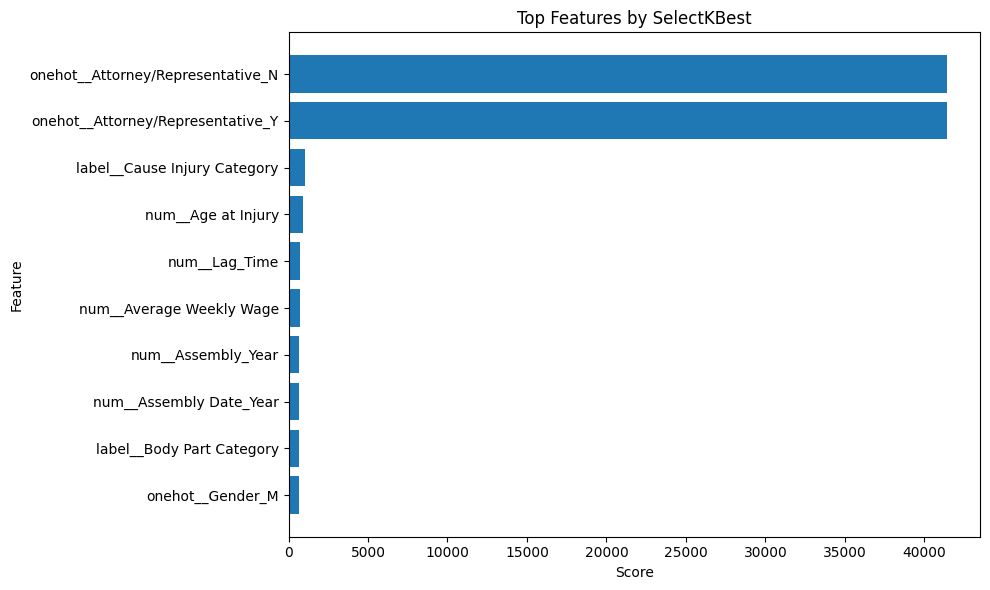

In [45]:
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Combine scores and feature names into a DataFrame
feature_scores_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': feature_scores
}).sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(feature_scores_df['Feature'].iloc[:10][::-1], feature_scores_df['Score'].iloc[:10][::-1])
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Top Features by SelectKBest')
plt.tight_layout()
plt.show()

# RFE CV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define the RFECV step with adjustments to LogisticRegression
rfecv_selector = RFECV(estimator=LogisticRegression(solver='saga', max_iter=1000), cv=3)

# Combine preprocessing and feature selection into a pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),       # Preprocess the data
    ('feature_selection', rfecv_selector)  # Perform RFECV
])

# Fit the pipeline on the training data
model_pipeline.fit(X_train, y_train)

# Get the selected features
selected_features = model_pipeline.named_steps['feature_selection'].support_
print("Selected features:", selected_features)

# Get the ranking of all features
feature_rankings = model_pipeline.named_steps['feature_selection'].ranking_
print("Feature rankings:", feature_rankings)


In [ ]:
# Get the feature names after preprocessing
feature_names_rfe = preprocessor.get_feature_names_out()

# Get the selected features (True/False mask)
selected_features_rfe = model_pipeline.named_steps['feature_selection'].support_

# Get the feature rankings
feature_rankings_rfe = model_pipeline.named_steps['feature_selection'].ranking_

# Combine feature names, rankings, and selected status into a DataFrame
feature_importance_df_rfe = pd.DataFrame({
    'Feature': feature_names_rfe,
    'Selected': selected_features_rfe,
    'Ranking': feature_rankings_rfe
}).sort_values(by='Ranking')

# Print the top-ranked features
print(feature_importance_df_rfe)

# Plot the ranking of the features
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_rfe['Feature'], feature_importance_df_rfe['Ranking'])
plt.xlabel('Ranking (Lower is Better)')
plt.ylabel('Features')
plt.title('Feature Importance Rankings by RFECV')
plt.gca().invert_yaxis()  # Reverse the y-axis to show the best features at the top
plt.tight_layout()
plt.show()